# Progressive Sampling
The general idea is to divide the data into bins of equal density. 
Then, we progressively maintain a representative set of points for each bin, to be able to capture the distributions of the entire dataset whenever we recompute the doi function or train the classifier.

This task is split into the following subtasks: 
1. compute the doi function over all items across all bins
2. rebin the data based on their doi values
3. update items in bins that have changed "too much"

## 1) Compute the doi function
For simplicity, we will use outlier detection here, which for every item computes, whether or not it is an outlier in the dataset, given an approximate "contamination" of the data.

In [2]:
from sklearn.ensemble import IsolationForest
doi = IsolationForest(contamination=0.1, random_state=0)

## 2) Binning
Given a distribution of floating point values, progressively maintain bins of equal density for them.

In [ ]:
import numpy as np
from random import random
from sklearn.datasets import make_blobs
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt

N = 10000
training_size = 100
features = 2
chunk_size = 1000
n_bins = 5

blobs_params = {"n_samples": N, "n_features": features}
hist_params = {"alpha": 0.73, "ec": "#000"}

binning = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")
X = make_blobs(centers=6, cluster_std=1, **blobs_params)[0]
y = doi.fit_predict(X)

distributions = [np.random.normal(random(), random() * 0.25, N) for _ in range(N//chunk_size)]
previous_hist = []

for i, distribution in enumerate(distributions):
  y_ = y + distribution

  binning.fit(y_.reshape(-1, 1))
  edges = binning.bin_edges_[0]
  bins = binning.transform(y_.reshape(-1, 1))
  bins = binning.inverse_transform(bins)

  fig, (ax1, ax2) = plt.subplots(2, 1)

  hist = np.histogram(y_, bins=edges)[0]
  if i > 0:
    delta_hist = hist - previous_hist
    ax2.bar(np.arange(0, n_bins), delta_hist, fc="orange", **hist_params)
    ax2.axhline(0, lw=1, c="black")
    ax2.axhline(N * 0.1, lw=1, c="black", dashes=[2])
    ax2.axhline(-N * 0.1, lw=1, c="black", dashes=[2])
    ax2.set_ylim([-N, N])
  previous_hist = hist

  ax1.set_title("chunk")
  ax1.set_ylim([0, N])
  ax1.hist(bins, bins=edges, fc="steelblue", **hist_params)
  ax1.hist(y_, fc="white", **hist_params)

## 3) Sampling
A good candidate seems to be so-called reservoir sampling, which progressively updates a representative sample of the data seen so far, thus at every point maintainnig a sample where each point may have been picked with probability := 1/(number of points processed so far).

See [https://dl.acm.org/doi/pdf/10.1145/3147.3165](https://dl.acm.org/doi/pdf/10.1145/3147.3165)

### 3.1 Naive chunk-based Reservoir sampling
Pseudo code:
```
# we progress over a dataset X of size N and want to maintain a progressive random sample S of 
# size n.
# Every item x_t from the dataset is numbered based on the timepoint t at which it is 
# processed: x_t with t \in [0 ... N]. We go through the data in linear order.
# for x_t in X:
  # if t <= n, then x_t is put into S.
  # otherwise, x_t becomes a candidate that may replace an item in S:
  #    generate a random integer r from the interval [0, t]. If r < n, then replace the item S[r] 
  #    with with x_t
# the probability of an item becoming part of the sample S is n/t and is decreasing with t.
# the probability of being replaced is higher, the longer an item is part of Sy.
```

In [ ]:
from sklearn.utils.random import sample_without_replacement
from random import randint
import numpy as np

reservoir = np.array([])
k = 5

X = np.arange(0, 1000)
chunk_size = 10

for i in range(0, len(X) // chunk_size):
  chunk = X[i * chunk_size:(i+1) * chunk_size]

  if i == 0:
    sample = sample_without_replacement(n_population=chunk_size, n_samples=k, random_state=i)
    reservoir = chunk[sample]
  else:
    candidates = np.array([randint(0, i*chunk_size) for _ in range(chunk_size)])
    picks = candidates[candidates < k]
    reservoir[picks] = chunk[picks]

reservoir

### 3.2 Optimized chunk-based Reservoir Sampling

Quote from the reservoir sampling paper:
> The random variable S(n, t) is defined to be the number of records in the file that are skipped over before the next record is chosen for the reservoir, where n is the size of the sample and where t is the number of records processed so far. For notational simplicity, we shall often write 9 for S(n, t),in which case the parameters n and t will be implicit.

In [ ]:
from sklearn.utils.random import sample_without_replacement
from random import randint
import numpy as np

reservoir = np.array([])
k = 5

X = np.arange(0, 1000)
chunk_size = 10

skip = k

for i in range(0, len(X) // chunk_size):
  chunk = X[i * chunk_size:(i+1) * chunk_size]

  if i == 0:
    sample = sample_without_replacement(n_population=chunk_size, n_samples=k, random_state=i)
    reservoir = chunk[sample]
    skip = randint(k, (i+1)*chunk_size)
  elif skip < i*chunk_size:
    candidate = chunk[skip % chunk_size]
    reservoir[randint(0, k-1)] = candidate
    skip = randint(k, i*chunk_size*2)

reservoir

## 4) Progressive Bin-based Sampling with Balanced Classes
Putting things together.

In [97]:
def sample_bins(X_, y_, X_res, y_res, skips, n_bins, k):
  replaced = {}
  for i in range(n_bins):
    replaced[i] = 0

  for j in range(n_bins):
    if len(bins[bins == j]) == 0:
      continue

    # find all items in this bin
    X_in_bin = X_[(bins == j).flatten()]
    y_in_bin = y_[(bins == j).flatten()]

    # find all items currently in the reservoir for this bin
    bin_reservoir_X = X_res[j]
    bin_reservoir_y = y_res[j]
    skip = skips[j]

    in_bin = len(X_in_bin)
    in_reservoir = len(bin_reservoir_X)

    # reservoir sample the bin using items assigned to this bin in the current iteration
    # before replacing, fill the reservoir
    if i == 0 or in_reservoir < k:
      # either pick all, if there is space, or just pick enough to fill
      if in_reservoir == 0 and in_bin < k:
        sample = np.arange(in_bin) # pick all elements in the chunk
      else:
        n_samples = np.min((k-in_reservoir, in_bin))
        sample = sample_without_replacement(n_population=in_bin, n_samples=n_samples, random_state=i)

      bin_reservoir_X = np.concatenate((bin_reservoir_X, X_in_bin[sample]))
      bin_reservoir_y = np.concatenate((bin_reservoir_y.reshape(-1,), y_in_bin[sample]))
      skip = randint(k, (i+1)*chunk_size)

    # replace items in the bin with a probability of 1/N per item throughout the progression
    else:
      while skip < i*chunk_size:
        candidate_X = X_in_bin[skip % len(X_in_bin)]
        candidate_y = y_in_bin[skip % len(X_in_bin)]
        pick = randint(0, k-1)
        bin_reservoir_X[pick] = candidate_X
        bin_reservoir_y[pick] = candidate_y
        skip = randint(k, (i+1)*chunk_size)
        replaced[i] += 1
    
    skips[j] = skip

    X_res[j] = bin_reservoir_X
    y_res[j] = bin_reservoir_y
  return X_reservoir, y_reservoir

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 3}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
{0: 0, 1

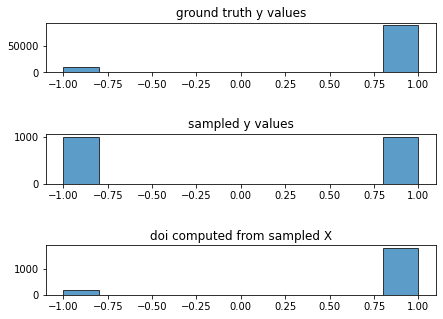

In [98]:
from random import randint
import numpy as np
from random import random
from sklearn.datasets import make_blobs
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.random import sample_without_replacement
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

N = 100000
features = 2
chunk_size = 1000

chunks = N // chunk_size
k = chunk_size
n_bins = 5

blobs_params = {"n_samples": N, "n_features": features}
hist_params = {"alpha": 0.73, "ec": "#000"}
binning = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")

X = make_blobs(centers=6, cluster_std=1, **blobs_params)[0]
y = doi.fit_predict(X)

# create empty reservoirs for the progressive sample per bin. Each bin reservoir contains teh 
X_reservoir: dict[str, list] = {} # progressively stores data
y_reservoir: dict[str, float] = {} # progressively stores doi

# for each bin, create an empty reservoir
for i in range(n_bins):
  X_reservoir[i] = np.empty((0, X.shape[1]))
  y_reservoir[i] = np.empty((0, 1))

skips = [k for _ in range(n_bins)]

# last iteration's per-bin mean values
previous_bin_means = np.array([])


for i in range(chunks):
  chunk = X[i*chunk_size:(i+1)*chunk_size]

  # compute the doi function over known items and the items in the new chunk
  reservoir = np.concatenate(tuple([X_reservoir[x] for x in X_reservoir]))
  X_ = np.append(chunk, reservoir, axis=0)
  y_ = doi.fit_predict(X_)

  # compute bins over these doi values
  binning.fit(y_.reshape(-1, 1))

  # item -> bin (index can be used for X_ and y_)
  bins = binning.transform(y_.reshape(-1, 1))

  # TODO: empty bin reservoirs "where needed" (some critieria that indicates that the bin values 
  # have shifted significantly)
  # TODO: check if per-bin mean has shifted
  # compute per-bin mean in new doi bins
  # new_means = np.array([y_[bins.flatten() == bin].mean() for bin in range(n_bins)])
  # new_means[np.isnan(new_means)] = 0
  # # compare new mean vs. old mean and check if it exceeds a threshold
  # if i > 0:
  #   mean_diff = new_means - previous_bin_means
  #   print("mean diff:", mean_diff)
  #   # TODO: check threshold
  # previous_bin_means = new_means


  # fill the reservoirs by drawing random samples from the data
  X_reservoir, y_reservoir = sample_bins(X_, y_, X_reservoir, y_reservoir, skips, n_bins, k)

plot()

In [95]:
def plot():
  # plot the results
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), gridspec_kw={"hspace": 1.25})
  ax1.set_title("ground truth y values")
  ax1.hist(y, **hist_params)

  ax2.set_title("sampled y values")
  sampled_ys = tuple([y_reservoir[i].reshape(-1, 1) for i in y_reservoir])
  print([s.shape for s in sampled_ys])
  sampled_y = np.concatenate(sampled_ys)
  ax2.hist(sampled_y, **hist_params)

  ax3.set_title("doi computed from sampled X")
  reservoir = np.concatenate(tuple([X_reservoir[x] for x in X_reservoir]))
  sampled_X_y = doi.fit_predict(reservoir)
  ax3.hist(sampled_X_y, **hist_params)